In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, RepeatVector

from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve, roc_auc_score

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./dataset/new_credit/data7.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df = data.copy()

In [4]:
# 시간을 일중 시간으로 변경
df.loc[:,'Time'] = df.loc[:,'Time'].apply(lambda x:x/3600%24)

# Amount 값에 log를 취함
eps = 0.001 # log는 log0가 되면 무한대가 되기 때문에 0을 방지
df.loc[:,'Amount'] = np.log(df.loc[:,'Amount'] + eps)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008105,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989913,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936641,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816249,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248367,0


# Feature selection

In [5]:
# df = df[['V1','V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18','V19','Amount','Class']]
df = df[['V17','V12','V14','V4','V16','V18','V10','V11','V5','V3','V9','V1','V8','V7','V2','V19','V21','V20','Amount','V15','Class']]
df

,V17,V12,V14,V4,V16,V18,V10,V11,V5,V3,...,V1,V8,V7,V2,V19,V21,V20,Amount,V15,Class
0,0.207971,-0.617801,-0.311169,1.378155,-0.470401,0.025791,0.090794,-0.551600,-0.338321,2.536347,...,-1.359807,0.098698,0.239599,-0.072781,0.403993,-0.018307,0.251412,5.008105,1.468177,0
1,-0.114805,1.065235,-0.143772,0.448154,0.463917,-0.183361,-0.166974,1.612727,0.060018,0.166480,...,1.191857,0.085102,-0.078803,0.266151,-0.145783,-0.225775,-0.069083,0.989913,0.635558,0
2,1.109969,0.066084,-0.165946,0.379780,-2.890083,-0.121359,0.207643,0.624501,-0.503198,1.773209,...,-1.358354,0.247676,0.791461,-1.340163,-2.261857,0.247998,0.524980,5.936641,2.345865,0
3,-0.684093,0.178228,-0.287924,-0.863291,-1.059647,1.965775,-0.054952,-0.226487,-0.010309,1.792993,...,-0.966272,0.377436,0.237609,-0.185226,-1.232622,-0.108300,-0.208038,4.816249,-0.631418,0
4,-0.237033,0.538196,-1.119670,0.403034,-0.451449,-0.038195,0.753074,-0.822843,-0.407193,1.548718,...,-1.158233,-0.270533,0.592941,0.877737,0.803487,-0.009431,0.408542,4.248367,0.175121,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286304,1.991691,2.711941,4.626942,-2.066656,1.107641,0.510632,4.356170,-1.593105,-5.364473,-9.834783,...,-11.881118,7.305334,-4.918215,10.071785,-0.682920,0.213454,1.475829,-0.260067,-0.924459,0
286305,-0.025693,0.915802,-0.675143,-0.738589,-0.711757,-1.221179,-0.975926,-0.150189,0.868229,2.035030,...,-0.732789,0.294869,0.024330,-0.055080,-1.545556,0.214205,0.059616,3.210481,1.164931,0
286306,0.313502,0.063119,-0.510602,-0.557828,0.140716,0.395652,-0.484782,0.411614,2.630515,-3.249640,...,1.919565,0.708417,-0.296827,-0.301254,-0.577252,0.232045,0.001396,4.217756,1.329284,0
286307,0.509928,-0.962886,0.449624,0.689799,-0.608577,1.113981,-0.399126,-1.933849,-0.377961,0.702510,...,-0.240440,0.679145,-0.686180,0.530483,2.897849,0.265245,0.127434,2.302685,1.962563,0


In [6]:
from collections import Counter
LABELS = ['0', '1']
Counter(df['Class'])

Counter({0: 284315, 1: 1994})

<AxesSubplot: >

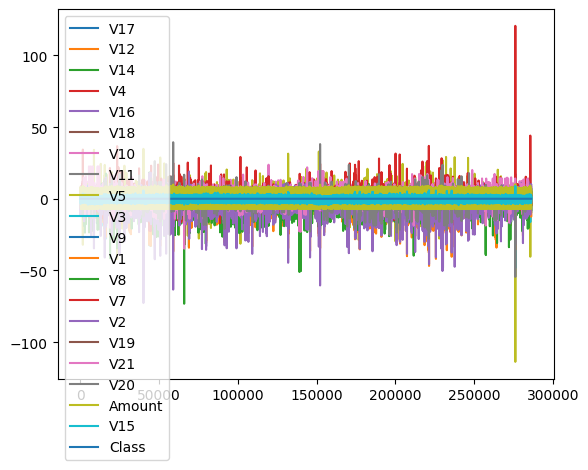

In [7]:
# # 정상 데이터 시각화
# df[df['Class']==0].plot()

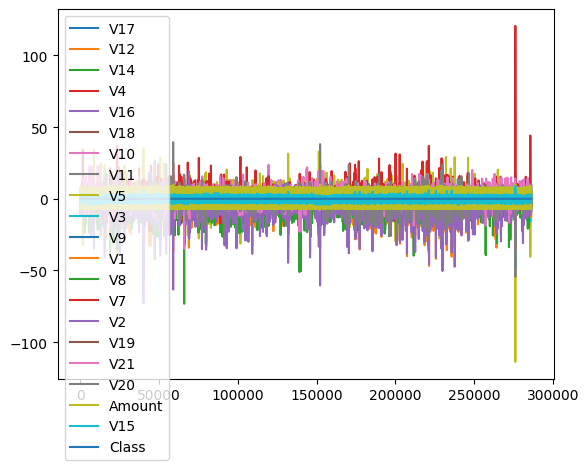

<AxesSubplot: >

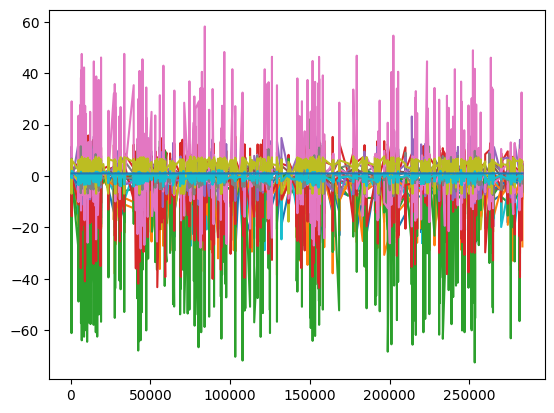

In [8]:
# # 사기 데이터 시각화
# df[df['Class']==1].plot(legend=False)

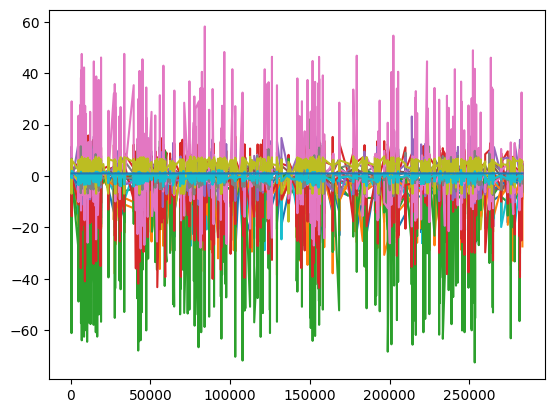

# 데이터, 라벨 분리

In [9]:
features = df.drop(['Class'], axis=1).values
labels = np.array(df.pop('Class'))

In [10]:
n_features = features.shape[1]

# 시퀀스 data 생성

In [11]:
# 모델에서 사용하기 위해 생성된 훈련 시퀀스
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [12]:
timesteps = 30

# Temporalize
x, y = temporalize(features, labels, timesteps)
print(x.shape) # (283695, 30, 15)

(286278, 30, 20)


# Train, Test 분리

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.5)

print(len(x_train))  # 71569
print(len(x_valid))  # 71570
print(len(x_test))   # 143139

71569
71570
143139


In [15]:
# For training the autoencoder, split 0 / 1
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

In [16]:
x_train_y0.shape

(71052, 30, 20)

# Standardize

In [17]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(flatten(x_train_y0))

x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

# LSTM Autoencoder model

In [19]:
model = Sequential()

model.add(LSTM(32, input_shape=(timesteps, n_features)))

model.add(Dropout(0.2))
model.add(RepeatVector(timesteps))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=True))
model.add(Dense(n_features))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6784      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 32)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 dense (Dense)               (None, 30, 20)            660       
                                                        

# Train

In [20]:
epochs = 100
batch = 64 #128,32

In [21]:
%%time
history = model.fit(x_train_y0_scaled, x_train_y0_scaled,
                    epochs=epochs, batch_size=batch, validation_data=(x_valid_y0_scaled,x_valid_y0_scaled),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")])

Epoch 1/100
1111/1111 [==============================] - 41s 25ms/step - loss: 1.2694 - val_loss: 1.2387
Epoch 2/100
1111/1111 [==============================] - 26s 24ms/step - loss: 1.2303 - val_loss: 1.2083
Epoch 3/100
1111/1111 [==============================] - 26s 24ms/step - loss: 1.2155 - val_loss: 1.1992
Epoch 4/100
1111/1111 [==============================] - 27s 24ms/step - loss: 1.2063 - val_loss: 1.1857
Epoch 5/100
1111/1111 [==============================] - 27s 25ms/step - loss: 1.2000 - val_loss: 1.1806
Epoch 6/100
1111/1111 [==============================] - 28s 25ms/step - loss: 1.1959 - val_loss: 1.1786
Epoch 7/100
1111/1111 [==============================] - 27s 24ms/step - loss: 1.1911 - val_loss: 1.1777
Epoch 8/100
1111/1111 [==============================] - 26s 24ms/step - loss: 1.1877 - val_loss: 1.1741
Epoch 9/100
1111/1111 [==============================] - 27s 24ms/step - loss: 1.1856 - val_loss: 1.1742
Epoch 10/100
1111/1111 [==============================]

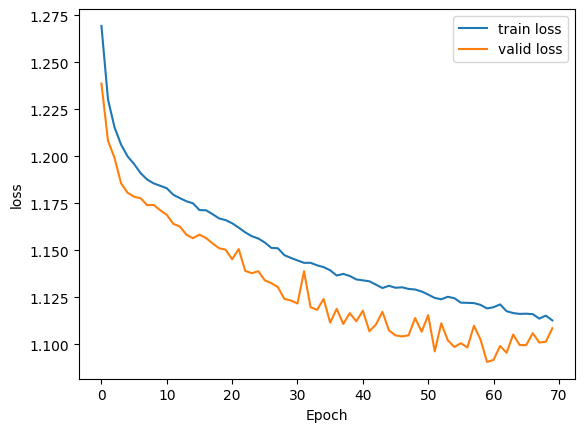

In [22]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

# Threshold

In [23]:
valid_x_predictions = model.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

2237/2237 [==============================] - 13s 5ms/step


In [24]:
error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(
    error_df['True_class'], error_df['Reconstruction_error'])

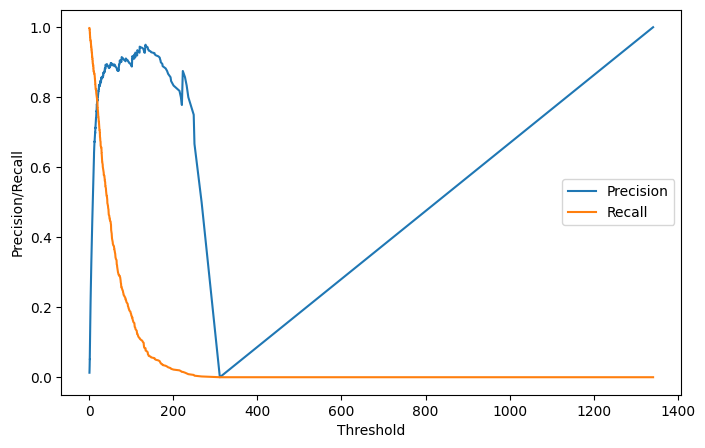

In [25]:
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [26]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.7908496732026143 , recall:  0.7908496732026143
threshold:  19.34744149837417


# Test

In [27]:
test_x_predictions = model.predict(x_test_scaled)

4474/4474 [==============================] - 24s 5ms/step


In [28]:
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)

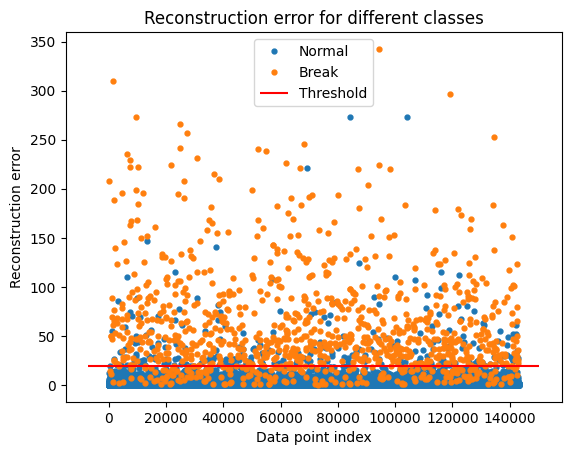

In [29]:
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Evaluation

f1 score: 0.7858869018849687
Accuracy 0.9969051062254173
Precision 0.7735490009514748
Recall 0.7986247544204322


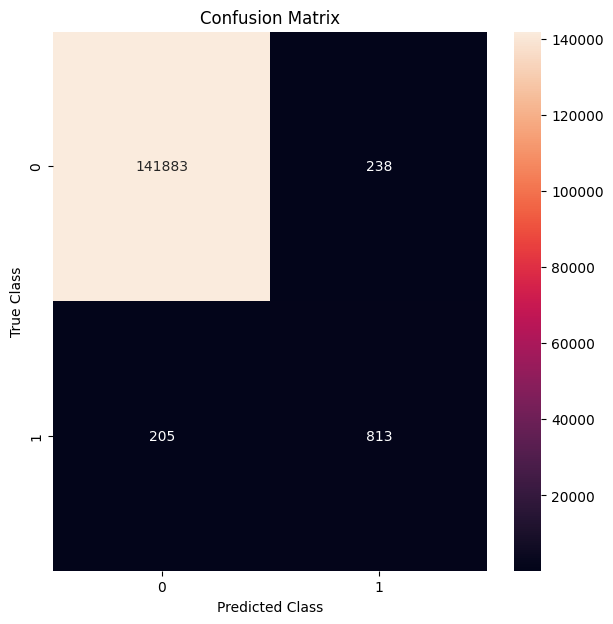

In [30]:
# classification by threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

print("f1 score:", f1_score(error_df['True_class'], pred_y))
print("Accuracy", accuracy_score(error_df['True_class'], pred_y))
print("Precision", precision_score(error_df['True_class'], pred_y))
print("Recall", recall_score(error_df['True_class'], pred_y))
    
conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

- f1 score: 0.7981972959439159
- Accuracy 0.9971845548732351
- Precision 0.805050505050505
- Recall 0.791459781529295

- f1 score: 0.7409669211195928
- Accuracy 0.9964440159565178
- Precision 0.7551867219917012
- Recall 0.7272727272727273